### The Linear Regression File 

#### questions to answer:
##### how many classes do ew need for each feature (currency) analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# test_list = ['first', 'second', 'third']
# final_dict = {}
# for i, element in enumerate(test_list):
# 	g = {'x' : i*i, 'y' : i+1}
# 	final_dict[element] = g
# print(final_dict)
# print(final_dict['second']['y'])
##############################################################################################################
arr = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
X = np.array([arr + (arr[-1]*i) for i in range(len(arr) - 2)])

def generate_y(array, horizon):
    close = array[:,4] ### 1)
    return close[horizon:] ### 2)


horizon = 7
G = X[:-horizon]
y = generate_y(X,horizon)

X_shape = X.shape
y_shape = y.shape

print(G.shape)
print(y_shape)


# # print(X)
# print(f'X.shape : {X.shape}')

# print('--'*25)

# horizon = 7
# G = X[:, :-horizon]
# # G = X
# J = G[:,4]

# print('--'*25)
# print(G)
# print(G.shape)
# print('--'*25)
# print(J)
# print(J.shape)
# print('--'*25)

# print('--'*25)

##############################################################################################################
# number of days since start | open | high | low | close | sma(10 days) | golden cross | death cross
#          0                 |  1   |  2   |  3  |   4   |      5       |      6       |      7

(3, 12)
(3,)


In [3]:
import preprocess
files = preprocess.potential_files[:5]

preprocess_class_instantiation = preprocess.preprocess(files, 7)

datasets = preprocess_class_instantiation.generate_data()

processing files
Loading 1INCH.csv...


100%|██████████| 85.6k/85.6k [00:00<00:00, 1.00MB/s]


Loading AAVE.csv...


100%|██████████| 84.5k/84.5k [00:00<00:00, 1.06MB/s]


Loading ADA.csv...


100%|██████████| 132k/132k [00:00<00:00, 982kB/s]


The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)
[205 263.47 264.177 226.298 233.556 260.98885714285717 0 0]
233.556
processing files
Loading 1INCH.csv...
Loading AAVE.csv...
Loading ADA.csv...
Loading ALGO.csv...


100%|██████████| 109k/109k [00:00<00:00, 879kB/s]


Loading AMP.csv...


100%|██████████| 99.0k/99.0k [00:00<00:00, 895kB/s]

The columns are: (number of days since start,open,high,low,close,sma(10 days),golden cross, death cross)


In [4]:
filename = '1INCH.csv'
print(f"observing X for {filename} :\n{datasets[filename]['X']}\n")

print(type(datasets[filename]['X']))
g = datasets[filename]['X']
print(g.shape)

TypeError: list indices must be integers or slices, not str

In [ ]:
# import test2233

In [ ]:
##### THIS IS THE CELL THAT I AM HAVING ISSUES WITH #####
# test_data = np.random.randint(0,30,size=(14,13))
X = None
y = None
currency_we_want_to_look_at = '1INCH.csv'
for key, value in datasets.items():
	if key == currency_we_want_to_look_at:
		X = datasets[key]['X']
		y = datasets[key]['y']
		# print(f'key : {key}\n{X}')
print(X.shape)
print('--'*50)
print(y.shape)

(1511, 9)
----------------------------------------------------------------------------------------------------
(1504,)


In [ ]:
X0 = X[:, [0]]
new_x = [20, 21, 99, 58, 67, 55, 33, 34, 35, 36, 37, 39]
lin_reg_model = LinearRegression()

print(f'X.shape : {X.shape}')
print(f'X0.shape : {X0.shape}')
print(f'y.shape : {y.shape}')





lin_reg_model.fit(X0, y)
y_pred = lin_reg_model.predict(X0)


fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(111)

ax.scatter(X0, y, color='blue', alpha=1, label='data')

ax.scatter(X0,y_pred, color='green')

for i in new_x:
	y_pred_new_x = lin_reg_model.predict(np.array([[i]]))[0]
	ax.scatter(i, y_pred_new_x, color='orange', marker='x', label=f'pred at {i}')
	# ax.text(i, y_pred_new_x, f'{y_pred_new_x:2f}', color='red')

# for x_value, y_value in zip(X0[:, 0], y_pred):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(2,1), fontsize=8, color='green')
    
# for x_value, y_value in zip(X0[:, 0], y):
#     # print(f'(x_value, y_value) : ({x_value}, {y_value})')
#     ax.annotate(f'({x_value}, {y_value})', (x_value,y_value), textcoords='offset fontsize', xytext=(1,1), fontsize=8, color='blue')

ax.plot(X0, y_pred, color='black', label='LOBF')

# for i in range(len(X0)):
#     ax.arrow(X0[i, 0],y_pred[i],0,y[i]-y_pred[i], length_includes_head=True, color='red')

# ax.set_xlabel('Days for this Feature')
# ax.set_ylabel('Value of the Target')
ax.legend()
ax.grid()
#################################################################################################################################
# lin_reg_model = LinearRegression()


# for i in range(1, 10):
# 	X0 = X[:, [i]]
# 	lin_reg_model.fit(X0, y)
# 	y_pred = lin_reg_model.predict(X0)
# 	fig = plt.figure(figsize=(1,1))
# 	ax  = fig.add_subplot(111)

# 	print(X0.shape)
# 	print(y.shape)

# 	ax.scatter(X0, y, color='blue', alpha=1, label='data')

# 	ax.scatter(X0,y_pred, color='green')
# 	ax.plot(X0, y_pred, color='black', label='LOBF')
# 	# ax.legend()
	# ax.grid()

X.shape : (1511, 9)
X0.shape : (1511, 1)
y.shape : (1504,)


ValueError: Found input variables with inconsistent numbers of samples: [1511, 1504]

ValueError: Found array with dim 3, while dim <= 2 is required by PolynomialFeatures.

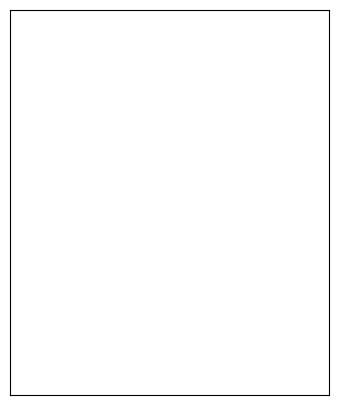

In [ ]:
# code based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)   

n_samples = 30
degrees = [1, 4, 15]

# X = np.sort(np.random.rand(n_samples))
# # print(X)
# y = true_fun(X) + np.random.randn(n_samples) * 0.1
# print(y)

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    Xs = np.linspace(0, 1, 100)
    plt.plot(Xs, pipeline.predict(Xs[:, np.newaxis]), label="Model")
    # print(f'---{pipeline.predict(Xs[:, np.newaxis])}---')
    
    plt.plot(Xs, true_fun(Xs), label="True function")
    
    plt.scatter(X, y, edgecolor='b', s=30, alpha=0.7,label="Training data")
##66666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666
    for j in range(n_samples):
        # Format the coordinates to two decimal places
        label = f'({X[j]:.2f}, {y[j]:.2f})'
        # Add a slight offset to the y-coordinate to place the label above the dot
        plt.text(X[j], y[j] + 0.08, label, fontsize=8, ha='center', color='red')
##66666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}".format(degrees[i]))
    
    
    
    
y_bad = y.copy()
y_bad[3] = -90

model1 = LinearRegression()
model1.fit(x[:, np.newaxis], y)

model2 = LinearRegression()
model2.fit(x[:, np.newaxis], y_bad)

xs = np.linspace(0, 10, 1000)
ys1 = model1.predict(xs[:, np.newaxis])
ys2 = model2.predict(xs[:, np.newaxis])

plt.figure(figsize=(4, 3))
plt.scatter(x, y_bad, alpha=0.5, color='green')
plt.scatter(x[3], y_bad[3], alpha=0.5, color='red')  ##<------ had to ask about this
plt.plot(xs, ys1, color='blue', label='model without outlier')
plt.plot(xs, ys2, color='purple', linestyle='-.', label='model WITH outlier')
